In [2]:
import pickle
import pandas as pd
import numpy as np


%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures



Building the model

Load test split set

In [7]:
with open('split_data.pkl', 'rb') as f:
    split_data = pickle.load(f)
(X, X_holdout, y, y_holdout) = split_data

Get rid of all the NaN

In [8]:
X.Skills.fillna('',inplace=True)
X_holdout.Skills.fillna('',inplace=True)
X['product'].fillna('',inplace=True)
X_holdout['product'].fillna('',inplace=True)

Make a train validation set for test purpose. Take out 15% for validation

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1765, random_state=21)

In [10]:
from sklearn.metrics import mean_squared_error
def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))

In [11]:
def test_model(model, X, y, X_val, y_val, alpha=None):
    '''test different sklearn models.
    '''
    if alpha:
        lm = model(alpha)
    else:
        lm = model()
    lm.fit(X,y)
    print(alpha,  'val R^2: %.5f' % lm.score(X_val, y_val))
    return (lm, lm.score(X_val, y_val))

In [12]:
def cross_validation_v2(X, y, model_list=None, alphas=None, cv=5):
    if not alphas:
        alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    if not model_list:
        model_list = [LinearRegression, Ridge, Lasso]
        
    kf = KFold(n_splits=cv, shuffle=True)
    
    if type(X) == pd.core.frame.DataFrame:
        X = X.values

    for model in model_list:
        print('model:', model)
        r2 = []
        if model != LinearRegression:
            scaler = StandardScaler()
            #X_train = scaler.fit_transform(X_train)
            #X_val = scaler.transform(X_val)
            for a in alphas:
                r2 = []
                for train_ind, val_ind in kf.split(X,y):
                    X_train, y_train = X[train_ind], y.iloc[train_ind]
                    X_val, y_val = X[val_ind], y.iloc[val_ind]
                    
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_val = scaler.transform(X_val)
                    
                    _, score = test_model(model, X_train, y_train, X_val, y_val, alpha=a)
                    r2.append(score)
                print('lambda %f, mean cv r^2: %.3f +- %.3f'%(a, np.mean(r2),np.std(r2)))
        else:       
            for train_ind, val_ind in kf.split(X,y):
                X_train, y_train = X[train_ind], y.iloc[train_ind]
                X_val, y_val = X[val_ind], y.iloc[val_ind]

                _, score = test_model(model, X_train, y_train, X_val, y_val, alpha=None)
                r2.append(score)
            print('mean cv r^2: %.3f +- %.3f'%(np.mean(r2),np.std(r2)))
   
          

#### Try simple linear regression

In [13]:
lm_features = ['401k','experience', 'free_food','insurance', 'visa', 'employees', 'investors',
       'open_jobs',  'size_', 'size_1-10', 'size_11-50',
       'size_201-500', 'size_51-200', 'degree_bs', 'degree_ms', 'degree_phd',
       'equity_low', 'equity_high',  'type_Contract',
       'type_Full Time', 'type_Internship']

In [14]:
lm = LinearRegression()
lm.fit(X_train[lm_features], y_train)
print('Linear Regression val R^2: %.3f', lm.score(X_val[lm_features], y_val))

Linear Regression val R^2: %.3f 0.20378864661161356


In [15]:
for i, j in zip(X_train[lm_features].columns, lm.coef_):
    print(i, j)

401k 9451.753644101815
experience 4145.921380761541
free_food -11517.663121257032
insurance 5054.488687769132
visa 7682.604603581771
employees 820.1254874299684
investors 348.42970502343996
open_jobs -819.6649758715998
size_ -3196.198959631798
size_1-10 -7611.644107421838
size_11-50 340.29888528425727
size_201-500 15447.5711130369
size_51-200 -4980.026931267296
degree_bs 3948.729276341954
degree_ms 8571.76700440337
degree_phd 16684.574350458097
equity_low -2786.643441728797
equity_high -311.2043309123974
type_Contract -25587.199732269793
type_Full Time -9414.308928208604
type_Internship -57283.79565599041


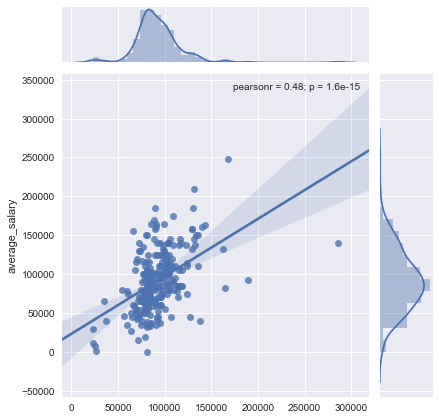

In [16]:
y_pred = lm.predict(X_val[lm_features])
sns.set()
sns.jointplot(y_pred,y_val, kind='regplot');

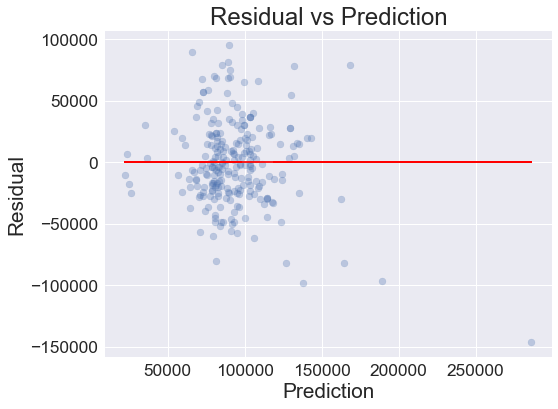

In [18]:
plt.figure(figsize = (8, 6))
plt.scatter(y_pred, y_val-y_pred, alpha=0.3)
plt.plot(y_pred, [0]*len(y_pred), 'r')
plt.title('Residual vs Prediction', fontsize=24)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Prediction', fontsize='xx-large')
plt.ylabel('Residual',fontsize='xx-large');

In [19]:
print(RMSE(y_val, y_pred))

34882.799332781986


Try to see if regularization help improve the model

In [20]:
cross_validation_v2(X[lm_features],y, [LinearRegression, Ridge, Lasso], [0.01, 0.1, 1, 10, 100, 1000], cv=5)

model: <class 'sklearn.linear_model.base.LinearRegression'>
None val R^2: 0.22121
None val R^2: 0.21483
None val R^2: 0.12499
None val R^2: 0.22628
None val R^2: 0.25472
mean cv r^2: 0.208 +- 0.044
model: <class 'sklearn.linear_model.ridge.Ridge'>
0.01 val R^2: 0.21989
0.01 val R^2: 0.18400
0.01 val R^2: 0.18746
0.01 val R^2: 0.25141
0.01 val R^2: 0.26574
lambda 0.010000, mean cv r^2: 0.222 +- 0.033
0.1 val R^2: 0.07456
0.1 val R^2: 0.31637
0.1 val R^2: 0.22649
0.1 val R^2: 0.24283
0.1 val R^2: 0.21527
lambda 0.100000, mean cv r^2: 0.215 +- 0.079
1 val R^2: 0.25270
1 val R^2: 0.18664
1 val R^2: 0.19690
1 val R^2: 0.18122
1 val R^2: 0.24198
lambda 1.000000, mean cv r^2: 0.212 +- 0.030
10 val R^2: 0.24105
10 val R^2: 0.12344
10 val R^2: 0.26965
10 val R^2: 0.17851
10 val R^2: 0.28096
lambda 10.000000, mean cv r^2: 0.219 +- 0.059
100 val R^2: 0.26089
100 val R^2: 0.27480
100 val R^2: 0.20687
100 val R^2: 0.17898
100 val R^2: 0.16046
lambda 100.000000, mean cv r^2: 0.216 +- 0.045
1000 val 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.1 val R^2: 0.16613
0.1 val R^2: 0.22758
0.1 val R^2: 0.24574
0.1 val R^2: 0.18025
lambda 0.100000, mean cv r^2: 0.218 +- 0.039
1 val R^2: 0.26047
1 val R^2: 0.15219
1 val R^2: 0.23451
1 val R^2: 0.16435
1 val R^2: 0.24455
lambda 1.000000, mean cv r^2: 0.211 +- 0.044
10 val R^2: 0.08073
10 val R^2: 0.19858
10 val R^2: 0.30207
10 val R^2: 0.16720
10 val R^2: 0.21525
lambda 10.000000, mean cv r^2: 0.193 +- 0.072
100 val R^2: 0.18347
100 val R^2: 0.26084
100 val R^2: 0.22898
100 val R^2: 0.20319
100 val R^2: 0.21713
lambda 100.000000, mean cv r^2: 0.219 +- 0.026
1000 val R^2: 0.22148
1000 val R^2: 0.19333
1000 val R^2: 0.15390
1000 val R^2: 0.28739
1000 val R^2: 0.18798
lambda 1000.000000, mean cv r^2: 0.209 +- 0.045


Regularization doens't improve R2. It seems like that the model is too biased.
#### Try log transform of the skewed features

In [21]:
def log_transform(df, colname_list):
    df_log = df.copy()
    for col in colname_list:
        colname = col + '_log'
        df_log[colname] = np.log(df[col])
    df_log.drop(columns = colname_list, inplace=True)   
    return df_log

In [22]:
X_log = log_transform(X[lm_features], ['employees', 'investors'] )
X_log['experience_log'] = np.log(X['experience']+1) #Some values in experience is zero

In [23]:
cross_validation_v2(X_log,y, [LinearRegression, Ridge, Lasso], [0.01, 0.1, 1, 10, 100, 1000], cv=5)

model: <class 'sklearn.linear_model.base.LinearRegression'>
None val R^2: 0.19476
None val R^2: 0.29505
None val R^2: 0.26733
None val R^2: 0.24580
None val R^2: 0.15803
mean cv r^2: 0.232 +- 0.050
model: <class 'sklearn.linear_model.ridge.Ridge'>
0.01 val R^2: 0.15739
0.01 val R^2: 0.24998
0.01 val R^2: 0.27680
0.01 val R^2: 0.21676
0.01 val R^2: 0.24812
lambda 0.010000, mean cv r^2: 0.230 +- 0.041
0.1 val R^2: 0.25068
0.1 val R^2: 0.20924
0.1 val R^2: 0.26221
0.1 val R^2: 0.17443
0.1 val R^2: 0.25504
lambda 0.100000, mean cv r^2: 0.230 +- 0.033
1 val R^2: 0.29135
1 val R^2: 0.24612
1 val R^2: 0.21768
1 val R^2: 0.22540
1 val R^2: 0.21039
lambda 1.000000, mean cv r^2: 0.238 +- 0.029
10 val R^2: 0.19999
10 val R^2: 0.25955
10 val R^2: 0.30217
10 val R^2: 0.21019
10 val R^2: 0.23955
lambda 10.000000, mean cv r^2: 0.242 +- 0.037
100 val R^2: 0.31988
100 val R^2: 0.26933
100 val R^2: 0.22400
100 val R^2: 0.25057
100 val R^2: 0.13985
lambda 100.000000, mean cv r^2: 0.241 +- 0.059
1000 val 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.1 val R^2: 0.26103
0.1 val R^2: 0.22108
0.1 val R^2: 0.24085
lambda 0.100000, mean cv r^2: 0.239 +- 0.055
1 val R^2: 0.26527
1 val R^2: 0.23451
1 val R^2: 0.19970
1 val R^2: 0.24633
1 val R^2: 0.23587
lambda 1.000000, mean cv r^2: 0.236 +- 0.021
10 val R^2: 0.19750
10 val R^2: 0.19644
10 val R^2: 0.29834
10 val R^2: 0.26101
10 val R^2: 0.23175
lambda 10.000000, mean cv r^2: 0.237 +- 0.039
100 val R^2: 0.23208
100 val R^2: 0.24181
100 val R^2: 0.14723
100 val R^2: 0.28533
100 val R^2: 0.23521
lambda 100.000000, mean cv r^2: 0.228 +- 0.045
1000 val R^2: 0.24742
1000 val R^2: 0.22567
1000 val R^2: 0.21185
1000 val R^2: 0.23895
1000 val R^2: 0.23582
lambda 1000.000000, mean cv r^2: 0.232 +- 0.012


Log Transformation improved the model a little bit, but not impressive.
#### Try add interaction to the model

In [25]:
interactions = PolynomialFeatures(degree=2, interaction_only=True)
X_interaction = interactions.fit_transform(X[lm_features])

In [26]:
cross_validation_v2(X_interaction, y, [LinearRegression, Ridge, Lasso], [100,500,600,700,1000,2000, 5000,7000], cv=5)

model: <class 'sklearn.linear_model.base.LinearRegression'>
None val R^2: -6.31427
None val R^2: 0.08161
None val R^2: 0.05160
None val R^2: -0.42615
None val R^2: -10130.14709
mean cv r^2: -2027.351 +- 4051.399
model: <class 'sklearn.linear_model.ridge.Ridge'>
100 val R^2: 0.20561
100 val R^2: 0.15654
100 val R^2: 0.09227
100 val R^2: 0.14655
100 val R^2: -4.37586
lambda 100.000000, mean cv r^2: -0.755 +- 1.811
500 val R^2: 0.11231
500 val R^2: -2.60548
500 val R^2: 0.21748
500 val R^2: 0.17956
500 val R^2: 0.22185
lambda 500.000000, mean cv r^2: -0.375 +- 1.116
600 val R^2: -1.34993
600 val R^2: 0.27997
600 val R^2: 0.28797
600 val R^2: 0.20086
600 val R^2: 0.23385
lambda 600.000000, mean cv r^2: -0.069 +- 0.641
700 val R^2: 0.18173
700 val R^2: 0.23261
700 val R^2: -0.90653
700 val R^2: 0.20829
700 val R^2: 0.21559
lambda 700.000000, mean cv r^2: -0.014 +- 0.447
1000 val R^2: 0.16560
1000 val R^2: -0.98567
1000 val R^2: 0.30816
1000 val R^2: 0.15232
1000 val R^2: 0.25523
lambda 1000

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


100 val R^2: 0.15471
100 val R^2: 0.22345
100 val R^2: -20.42326
100 val R^2: 0.06733
lambda 100.000000, mean cv r^2: -3.982 +- 8.221
500 val R^2: -0.13227
500 val R^2: -5.66276
500 val R^2: 0.22781
500 val R^2: 0.26348
500 val R^2: 0.25265
lambda 500.000000, mean cv r^2: -1.010 +- 2.331
600 val R^2: 0.21113
600 val R^2: 0.06682
600 val R^2: 0.29636
600 val R^2: 0.14333
600 val R^2: 0.25242
lambda 600.000000, mean cv r^2: 0.194 +- 0.081
700 val R^2: 0.13911
700 val R^2: 0.22194
700 val R^2: 0.17633
700 val R^2: 0.28174
700 val R^2: -20.00042
lambda 700.000000, mean cv r^2: -3.836 +- 8.082
1000 val R^2: 0.23674
1000 val R^2: 0.25511
1000 val R^2: 0.11932
1000 val R^2: 0.19503
1000 val R^2: 0.28725
lambda 1000.000000, mean cv r^2: 0.219 +- 0.058
2000 val R^2: 0.29738
2000 val R^2: 0.18538
2000 val R^2: 0.25416
2000 val R^2: 0.14304
2000 val R^2: 0.21958
lambda 2000.000000, mean cv r^2: 0.220 +- 0.053
5000 val R^2: 0.20276
5000 val R^2: 0.11970
5000 val R^2: 0.14997
5000 val R^2: 0.17741


Adding interaction doesn't help. 
#### Try add location as dummy variable

In [29]:
with open('df4.pkl', 'rb') as f:
    df4 = pickle.load(f)

In [30]:
df4.shape

(1601, 32)

In [32]:
location_dummies = df4.location_tag.str.get_dummies(',')

In [33]:
df5 = df4.copy()

In [34]:
for col in location_dummies.columns:
    colname = 'location_' + col
    df5[colname] = location_dummies[col] 

In [36]:
df5 = df5.drop(columns = ['location_tag','average_salary'])

X5 = df5.loc[X.index]
features_to_drop = ['Skills', 'currency', 'description',  'name', 'title', 'url_j',  'concept', 
                    'product', 'tags']
X_location = X5.drop(columns=features_to_drop)

In [37]:
df5.Skills.fillna('', inplace=True)
df5['product'].fillna('', inplace=True)

In [38]:
X_location.shape

(1360, 210)

In [ ]:
with open('df5.pkl', 'wb') as f:
    pickle.dump(df5, f)

In [39]:
cross_validation_v2(X_location, y, alphas=[0.0001,0.001,0.01, 1, 10, 100, 1000, 10000])

model: <class 'sklearn.linear_model.base.LinearRegression'>
None val R^2: -18005682319139.14062
None val R^2: -2739851669413814.00000
None val R^2: -7009429880132652032.00000
None val R^2: -63970082841127032.00000
None val R^2: -835287800783241.50000
mean cv r^2: -1415398621625259008.000 +- 2797121424976713728.000
model: <class 'sklearn.linear_model.ridge.Ridge'>
0.0001 val R^2: 0.32776
0.0001 val R^2: 0.28713
0.0001 val R^2: 0.32560
0.0001 val R^2: 0.40140
0.0001 val R^2: 0.35843
lambda 0.000100, mean cv r^2: 0.340 +- 0.038
0.001 val R^2: 0.40926
0.001 val R^2: 0.38423
0.001 val R^2: 0.31302
0.001 val R^2: 0.41161
0.001 val R^2: 0.29678
lambda 0.001000, mean cv r^2: 0.363 +- 0.049
0.01 val R^2: 0.39184
0.01 val R^2: 0.36503
0.01 val R^2: 0.36513
0.01 val R^2: 0.33297
0.01 val R^2: 0.33205
lambda 0.010000, mean cv r^2: 0.357 +- 0.023
1 val R^2: 0.43162
1 val R^2: 0.34340
1 val R^2: 0.27065
1 val R^2: 0.15305
1 val R^2: 0.33613
lambda 1.000000, mean cv r^2: 0.307 +- 0.092
10 val R^2: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0001 val R^2: 0.25930
0.0001 val R^2: 0.29899
0.0001 val R^2: 0.37017
0.0001 val R^2: 0.43200
0.0001 val R^2: 0.41325
lambda 0.000100, mean cv r^2: 0.355 +- 0.066
0.001 val R^2: 0.36516
0.001 val R^2: 0.34062
0.001 val R^2: 0.38956
0.001 val R^2: 0.26768
0.001 val R^2: 0.38718
lambda 0.001000, mean cv r^2: 0.350 +- 0.045
0.01 val R^2: 0.35514
0.01 val R^2: 0.27501
0.01 val R^2: 0.49469
0.01 val R^2: 0.40799
0.01 val R^2: 0.22815
lambda 0.010000, mean cv r^2: 0.352 +- 0.095
1 val R^2: 0.40754
1 val R^2: 0.38976
1 val R^2: 0.36115
1 val R^2: 0.31865
1 val R^2: 0.34104
lambda 1.000000, mean cv r^2: 0.364 +- 0.032
10 val R^2: 0.32763
10 val R^2: 0.26754
10 val R^2: 0.45083
10 val R^2: 0.27028
10 val R^2: 0.29474
lambda 10.000000, mean cv r^2: 0.322 +- 0.068
100 val R^2: 0.16091
100 val R^2: 0.41294
100 val R^2: 0.36165
100 val R^2: 0.37718
100 val R^2: 0.31748
lambda 100.000000, mean cv r^2: 0.326 +- 0.088
1000 val R^2: 0.39510
1000 val R^2: 0.32782
1000 val R^2: 0.38128
1000 val R^2: 0.

Adding location improves the model. Try adding text features using CountVectorizer()

In [40]:
def NPL_tranform(X_train_feature, X_val_feature, maxfeature=200):
    vectorizer = CountVectorizer(stop_words='english',max_features=maxfeature)
    vectorizer.fit(X_train_feature)
    train_vector = vectorizer.transform(X_train_feature)
    val_vector = vectorizer.transform(X_val_feature)
    preffix = X_train_feature.name
    #print(preffix)
    colnames = [] 
    for name in vectorizer.get_feature_names():
        colnames.append(preffix + '_' + name)
    #colnames = vectorizer.get_feature_names()
    #print('NPL_tranform', train_vector.shape, val_vector.shape)
    return (train_vector.toarray(), val_vector.toarray(), colnames)

In [41]:
def cross_validation_NPL(X, y, feature, model_list=None, alphas=None, cv=5, maxfeature=200):
    if not alphas:
        alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    if not model_list:
        model_list = [LinearRegression, Ridge, Lasso]
        
    kf = KFold(n_splits=cv, shuffle=True)
    
    if type(X) == pd.core.frame.DataFrame:
        x = X.values
    
    res = defaultdict(list)
    i = 0
        
    for train_ind, val_ind in kf.split(x,y):
        i+=1
        X_train, y_train = x[train_ind], y.iloc[train_ind]
        X_val, y_val = x[val_ind], y.iloc[val_ind]
        #(X_train_vector, X_val_vector, colname) = NPL_tranform(X_train[feature], X_val[feature])
        X_train_vector, X_val_vector, colname = NPL_tranform(feature.iloc[train_ind], feature.iloc[val_ind])
        #print(X_train.shape, X_train_vector.shape,type(X_train), type(X_train_vector.shape) )
        X_train_all_feature = np.concatenate((X_train, X_train_vector), axis=1)
        X_val_all_feature = np.concatenate((X_val, X_val_vector), axis=1)
    
        for model in model_list:
            #print('model:', model)
            if model != LinearRegression:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train_all_feature)
                X_val = scaler.transform(X_val_all_feature)
                
                for a in alphas:
                    _, score = test_model(model, X_train, y_train, X_val, y_val, alpha=a)
                    res[model,a].append(score)       
            else:
                _, score = test_model(model, X_train, y_train, X_val, y_val, alpha=None)
                res[model].append(score)

    for key in res:
        r2 = res[key]
        print(key)
        print('mean cv r^2: %.3f +- %.3f'%(np.mean(r2),np.std(r2)))
        
        

In [42]:
cross_validation_NPL(X_location, y, X['Skills'], model_list=None, alphas=list(np.linspace(250, 1500, 10)), cv=5, maxfeature=200)

None val R^2: -3774523208125.93408
250.0 val R^2: 0.43926
388.8888888888889 val R^2: 0.44037
527.7777777777778 val R^2: 0.43499
666.6666666666666 val R^2: 0.42704
805.5555555555555 val R^2: 0.41804
944.4444444444445 val R^2: 0.40867
1083.3333333333333 val R^2: 0.39926
1222.2222222222222 val R^2: 0.39001
1361.111111111111 val R^2: 0.38099
1500.0 val R^2: 0.37226
250.0 val R^2: 0.45863
388.8888888888889 val R^2: 0.47902
527.7777777777778 val R^2: 0.48349
666.6666666666666 val R^2: 0.48145
805.5555555555555 val R^2: 0.47517
944.4444444444445 val R^2: 0.46747
1083.3333333333333 val R^2: 0.45956
1222.2222222222222 val R^2: 0.45166
1361.111111111111 val R^2: 0.44274
1500.0 val R^2: 0.43329
None val R^2: -727610884147237.12500
250.0 val R^2: 0.37841
388.8888888888889 val R^2: 0.38950
527.7777777777778 val R^2: 0.39255
666.6666666666666 val R^2: 0.39159
805.5555555555555 val R^2: 0.38840
944.4444444444445 val R^2: 0.38391
1083.3333333333333 val R^2: 0.37864
1222.2222222222222 val R^2: 0.37292


Adding Skills further improved the model. Try adding more features.

In [43]:
def cross_validation_NPL_multiple(X, y, features=None, model_list=None, alphas=None, cv=5, maxfeature=200):
    if not alphas:
        alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    if not model_list:
        model_list = [LinearRegression, Ridge, Lasso]
        
    kf = KFold(n_splits=cv, shuffle=True)
    
    if type(X) == pd.core.frame.DataFrame:
        x = X.values
    
    res = defaultdict(list)
    model_dict = defaultdict(list)
    col_dict = defaultdict(list)
    i = 0
        
    for train_ind, val_ind in kf.split(x,y):
        i+=1
        X_train, y_train = x[train_ind], y.iloc[train_ind]
        X_val, y_val = x[val_ind], y.iloc[val_ind]
        col = list(X.columns)
        for feature in features:
            X_train_vector, X_val_vector, colname = NPL_tranform(feature.iloc[train_ind], feature.iloc[val_ind], maxfeature=maxfeature)
        #print(X_train.shape, X_train_vector.shape,type(X_train), type(X_train_vector.shape) )
            X_train = np.concatenate((X_train, X_train_vector), axis=1)
            X_val = np.concatenate((X_val, X_val_vector), axis=1)
            #print(X_train.shape, X_val.shape)
            col.extend(colname)
    
        for model in model_list:
            #print('model:', model)
            if model != LinearRegression:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
                
                for a in alphas:
                    lm, score = test_model(model, X_train, y_train, X_val, y_val, alpha=a)
                    res[model,a].append(score)  
                    model_dict[model,a].append(lm)
                    col_dict[model,a].append(col)
                    
            else:
                lm, score = test_model(model, X_train, y_train, X_val, y_val, alpha=None)
                res[model].append(score)
                model_dict[model].append(lm)
                col_dict[model].append(col)

    for key in res:
        r2 = res[key]
        print(key)
        print('mean cv r^2: %.3f +- %.3f'%(np.mean(r2),np.std(r2)))
    return model_dict, col_dict

In [44]:
#add skills and tags
models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.tags], model_list=None, 
                              alphas=[10,100, 500, 750,1000], cv=5, maxfeature=1000)

None val R^2: -4606.19242
10 val R^2: -0.85284
100 val R^2: 0.18264
500 val R^2: 0.40810
750 val R^2: 0.42104
1000 val R^2: 0.42078


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 val R^2: -1.84580
100 val R^2: 0.06726
500 val R^2: 0.43170
750 val R^2: 0.43551
1000 val R^2: 0.43946
None val R^2: -1672.50758
10 val R^2: -0.17670
100 val R^2: 0.31533
500 val R^2: 0.36663
750 val R^2: 0.35827
1000 val R^2: 0.34767
10 val R^2: -1.20571
100 val R^2: 0.28068
500 val R^2: 0.39745
750 val R^2: 0.39784
1000 val R^2: 0.39414
None val R^2: -28276.29130
10 val R^2: -0.44323
100 val R^2: 0.23408
500 val R^2: 0.33795
750 val R^2: 0.34273
1000 val R^2: 0.34042
10 val R^2: -1.07927
100 val R^2: 0.14902
500 val R^2: 0.40016
750 val R^2: 0.40743
1000 val R^2: 0.40802
None val R^2: -258.66414
10 val R^2: -0.66847
100 val R^2: 0.21646
500 val R^2: 0.38716
750 val R^2: 0.40095
1000 val R^2: 0.40361
10 val R^2: -1.83299
100 val R^2: 0.10846
500 val R^2: 0.39330
750 val R^2: 0.42181
1000 val R^2: 0.42635
None val R^2: -415.94221
10 val R^2: -0.59046
100 val R^2: 0.21916
500 val R^2: 0.38912
750 val R^2: 0.40532
1000 val R^2: 0.41012
10 val R^2: -1.86531
100 val R^2: 0.14403
500 val

In [45]:
#add skills, tags and title

models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.tags, X.title], model_list=None, 
                              alphas=[10,100, 500, 750,1000], cv=5, maxfeature=1000)

None val R^2: -50102704324082.98438
10 val R^2: 0.08919
100 val R^2: 0.43592
500 val R^2: 0.51580
750 val R^2: 0.51376
1000 val R^2: 0.50551


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 val R^2: 0.00568
100 val R^2: 0.40519
500 val R^2: 0.54074
750 val R^2: 0.54346
1000 val R^2: 0.54017
None val R^2: -78.32023
10 val R^2: -0.06836
100 val R^2: 0.32371
500 val R^2: 0.43211
750 val R^2: 0.43769
1000 val R^2: 0.43551
10 val R^2: -0.45359
100 val R^2: 0.31412
500 val R^2: 0.45797
750 val R^2: 0.47992
1000 val R^2: 0.48153
None val R^2: -32751305399884.57422
10 val R^2: -0.17285
100 val R^2: 0.41475
500 val R^2: 0.51637
750 val R^2: 0.51540
1000 val R^2: 0.50828
10 val R^2: -0.40399
100 val R^2: 0.42454
500 val R^2: 0.56923
750 val R^2: 0.56216
1000 val R^2: 0.54211
None val R^2: -59.34085
10 val R^2: -0.12483
100 val R^2: 0.41304
500 val R^2: 0.47716
750 val R^2: 0.46936
1000 val R^2: 0.45931
10 val R^2: -0.45817
100 val R^2: 0.45340
500 val R^2: 0.54435
750 val R^2: 0.52964
1000 val R^2: 0.50782
None val R^2: -1057836336859746.00000
10 val R^2: -0.09405
100 val R^2: 0.37747
500 val R^2: 0.45563
750 val R^2: 0.44931
1000 val R^2: 0.43919
10 val R^2: -0.49426
100 val R^

In [46]:
#add skills and tags, title and job description

models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.tags, X.title, X.description], model_list=None, 
                              alphas=[10,100, 500, 750,1000], cv=5, maxfeature=1000)

None val R^2: -0.46359
10 val R^2: 0.30059
100 val R^2: 0.37888
500 val R^2: 0.44369
750 val R^2: 0.45362
1000 val R^2: 0.45738


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 val R^2: 0.24312
100 val R^2: 0.40355
500 val R^2: 0.48138
750 val R^2: 0.48813
1000 val R^2: 0.48606
None val R^2: -0.17200
10 val R^2: 0.45342
100 val R^2: 0.51546
500 val R^2: 0.54606
750 val R^2: 0.54338
1000 val R^2: 0.53764
10 val R^2: 0.35857
100 val R^2: 0.48547
500 val R^2: 0.54465
750 val R^2: 0.54877
1000 val R^2: 0.52942
None val R^2: -0.04877
10 val R^2: 0.44161
100 val R^2: 0.47865
500 val R^2: 0.49255
750 val R^2: 0.48573
1000 val R^2: 0.47737
10 val R^2: 0.37593
100 val R^2: 0.51244
500 val R^2: 0.51933
750 val R^2: 0.50167
1000 val R^2: 0.47825
None val R^2: -0.42865
10 val R^2: 0.34427
100 val R^2: 0.42859
500 val R^2: 0.50525
750 val R^2: 0.51505
1000 val R^2: 0.51745
10 val R^2: 0.23824
100 val R^2: 0.39605
500 val R^2: 0.53665
750 val R^2: 0.55472
1000 val R^2: 0.55211
None val R^2: -0.40700
10 val R^2: 0.36720
100 val R^2: 0.42913
500 val R^2: 0.49955
750 val R^2: 0.51005
1000 val R^2: 0.51352
10 val R^2: 0.24788
100 val R^2: 0.38178
500 val R^2: 0.51921
750 va

In [47]:
#add skills and tags, titel, job description and company product 

models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.tags, X.title, X.description, X['product']], model_list=None, 
                              alphas=[10,100, 500, 750,1000], cv=5, maxfeature=1000)

None val R^2: -0.03486
10 val R^2: 0.37240
100 val R^2: 0.41664
500 val R^2: 0.45372
750 val R^2: 0.45825
1000 val R^2: 0.45871


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 val R^2: 0.29268
100 val R^2: 0.39128
500 val R^2: 0.48500
750 val R^2: 0.48969
1000 val R^2: 0.48514
None val R^2: -0.02465
10 val R^2: 0.35645
100 val R^2: 0.41773
500 val R^2: 0.47589
750 val R^2: 0.48873
1000 val R^2: 0.49564
10 val R^2: 0.23686
100 val R^2: 0.32755
500 val R^2: 0.48551
750 val R^2: 0.50212
1000 val R^2: 0.49362
None val R^2: -0.02477
10 val R^2: 0.43321
100 val R^2: 0.47113
500 val R^2: 0.51087
750 val R^2: 0.51682
1000 val R^2: 0.51867
10 val R^2: 0.28116
100 val R^2: 0.38111
500 val R^2: 0.50874
750 val R^2: 0.52167
1000 val R^2: 0.52031
None val R^2: 0.15672
10 val R^2: 0.56745
100 val R^2: 0.58390
500 val R^2: 0.59520
750 val R^2: 0.59412
1000 val R^2: 0.59084
10 val R^2: 0.47709
100 val R^2: 0.52211
500 val R^2: 0.58587
750 val R^2: 0.58467
1000 val R^2: 0.57009
None val R^2: 0.10916
10 val R^2: 0.41096
100 val R^2: 0.42640
500 val R^2: 0.44995
750 val R^2: 0.45334
1000 val R^2: 0.45362
10 val R^2: 0.41614
100 val R^2: 0.48315
500 val R^2: 0.54711
750 val 

Tried refining alpha

In [48]:
models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.tags, X.title, X.description, X['product']], model_list=None, 
                              alphas=list(np.linspace(500, 760, 14)), cv=5, maxfeature=1000)

None val R^2: 0.28039
500.0 val R^2: 0.56064
520.0 val R^2: 0.56110
540.0 val R^2: 0.56152
560.0 val R^2: 0.56190
580.0 val R^2: 0.56224
600.0 val R^2: 0.56254
620.0 val R^2: 0.56281
640.0 val R^2: 0.56305
660.0 val R^2: 0.56325
680.0 val R^2: 0.56343
700.0 val R^2: 0.56359
720.0 val R^2: 0.56372
740.0 val R^2: 0.56383
760.0 val R^2: 0.56391
500.0 val R^2: 0.58292
520.0 val R^2: 0.58457
540.0 val R^2: 0.58572
560.0 val R^2: 0.58668
580.0 val R^2: 0.58691
600.0 val R^2: 0.58697
620.0 val R^2: 0.58687
640.0 val R^2: 0.58651
660.0 val R^2: 0.58608
680.0 val R^2: 0.58566
700.0 val R^2: 0.58529
720.0 val R^2: 0.58467
740.0 val R^2: 0.58403
760.0 val R^2: 0.58321
None val R^2: 0.16184
500.0 val R^2: 0.47949
520.0 val R^2: 0.47961
540.0 val R^2: 0.47971
560.0 val R^2: 0.47979
580.0 val R^2: 0.47985
600.0 val R^2: 0.47988
620.0 val R^2: 0.47990
640.0 val R^2: 0.47990
660.0 val R^2: 0.47988
680.0 val R^2: 0.47985
700.0 val R^2: 0.47980
720.0 val R^2: 0.47974
740.0 val R^2: 0.47966
760.0 val R^2

#### Final Model: 
- Lasso
- alpha = 660
- maxfeature 1000

In [49]:
X_holdout_location=df5.loc[X_holdout.index]
#features_to_drop = ['Skills', 'currency', 'description',  'name', 'title', 'url_j',  'concept', 
#                    'product', 'tags']
holdout_features = X_holdout_location.copy()
X_holdout_location= X_holdout_location.drop(columns=features_to_drop)

In [50]:
col = list(X_location.columns)
X_train = X_location
X_val = X_holdout_location
for feature, val_feature in zip([X.Skills, X.tags, X.title, X.description, X['product']], 
                                [holdout_features.Skills, holdout_features.tags, holdout_features.title, holdout_features.description, holdout_features['product']]):
    X_train_vector, X_test_vector, colname = NPL_tranform(feature, val_feature, maxfeature=1000)
    #print(X_train.shape, X_train_vector.shape,type(X_train), type(X_train_vector.shape) )
    X_train = np.concatenate((X_train, X_train_vector), axis=1)
    X_val = np.concatenate((X_val, X_test_vector), axis=1)
    #print(X_train.shape, X_val.shape)
    col.extend(colname)
        
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
lm, score = test_model(Lasso, X_train, y, X_val, y_holdout, alpha=660)

print('r2:', score)


660 val R^2: 0.63895
r2: 0.6389528180283528


In [51]:
y_pred = lm.predict(X_val)
RMSE(y_pred, y_holdout)

24169.118947074403

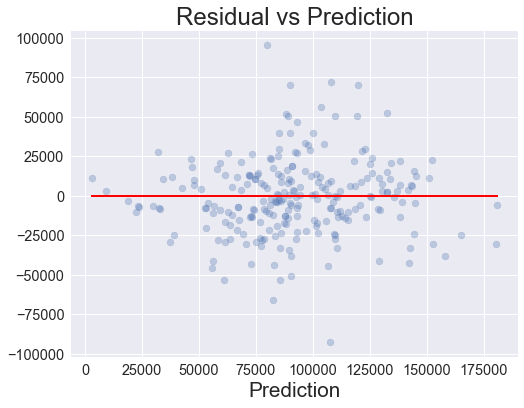

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred, y_holdout-y_pred, alpha=0.3)
plt.plot(y_pred, [0]*len(y_pred), 'r')
plt.title('Residual vs Prediction', fontsize=24)
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.xlabel('Prediction', fontsize='xx-large');

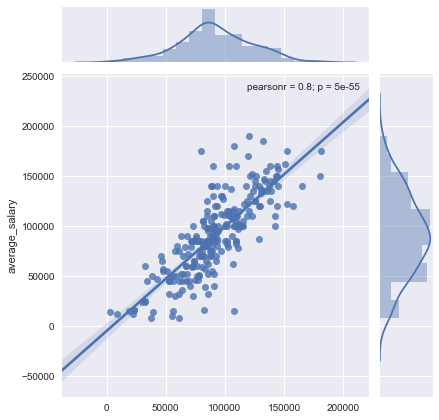

In [53]:
sns.jointplot(y_pred, y_holdout, kind='regplot');

In [54]:
coef_list=[]
for i, j in zip(col,lm.coef_ ):
    coef_list.append((i,j))
len(coef_list)

4284

In [55]:
non_zero = [x for x in coef_list if x[1]!= 0.0 ]
len(non_zero)

549

Total 4284 features used in the model. 549 Features remained after Lasso. To print the top10 positive and negative features

In [56]:
sorted(coef_list, key=lambda x: x[1], reverse=True)[:10]

[('location_San Francisco', 7929.028430480786),
 ('location_Palo Alto', 4483.735811396883),
 ('location_New York City', 3550.300007809017),
 ('title_senior', 3507.3671000359795),
 ('experience', 3355.345279848387),
 ('title_president', 2829.6712535392066),
 ('title_head', 2549.3906065924807),
 ('title_vp', 2513.251100309145),
 ('employees', 2421.0538789033476),
 ('tags_china', 2365.0076948128385)]

In [57]:
sorted(coef_list, key=lambda x: x[1])[:10]

[('location_Berlin', -3459.270330621442),
 ('type_Internship', -3415.452485313717),
 ('title_intern', -3305.026130761517),
 ('location_Paris', -3020.0477570042717),
 ('size_1-10', -2677.138785374904),
 ('title_analyst', -2239.742551552147),
 ('location_London', -2183.227268711077),
 ('location_Bengaluru', -2006.162668711753),
 ('equity_high', -1978.2822536617998),
 ('location_Bangkok', -1961.4573743327644)]